In [0]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [0]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [0]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

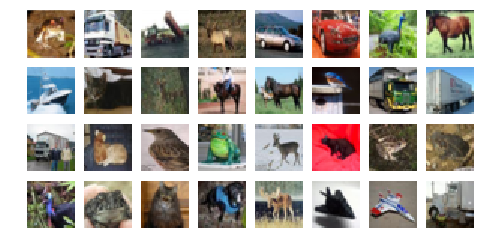

In [95]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [0]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

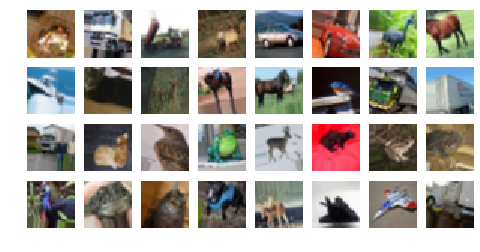

In [97]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

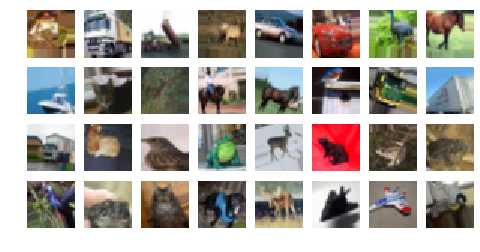

In [98]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

In [100]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train: ", x_train.shape)
print("x_test:  ", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

x_train:  (50000, 32, 32, 3)
x_test:   (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)


In [101]:
# Preprocessing / normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print("x_train: ", x_train.shape)
print("x_test:  ", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

x_train:  (50000, 32, 32, 3)
x_test:   (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)


In [0]:
def cnn_model(input_shape, output_units=10, num_neurons=[512, 256,128]):
    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", strides=1, padding='same', name="input_layer")(input_layer)
    x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", strides=1, padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", strides=1, padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", strides=1, padding='same')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    x = keras.layers.Flatten()(x)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dropout(0.25)(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dropout(0.25)(x)
            
    output_layer = keras.layers.Dense(units=output_units, activation="softmax", name="output_layer")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model



In [0]:
# Hyperparameters
lr = 1e-3
momentum = .95
batch_size = 128
epochs = 20

In [0]:
augment_generator = ImageDataGenerator(rotation_range=10, 
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1, 
                                       horizontal_flip=True
                                      )

In [105]:
# Create SGD optimizer
sgd = keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=True)

# Create model
model = cnn_model(x_train.shape[1:])
model.summary()
model.compile(optimizer=sgd,metrics=['accuracy'], loss='categorical_crossentropy')
history = model.fit_generator(augment_generator.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(x_train)/batch_size,
                              epochs=epochs,
                              verbose=1,
                              shuffle=False,
                              validation_data=(x_test, y_test)
                             )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
input_layer (Conv2D)         (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 32)          18464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 32)          0         
__________

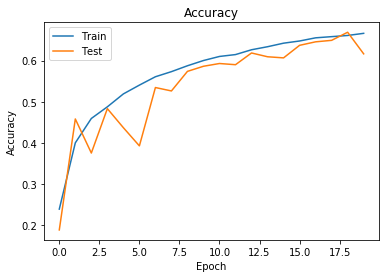

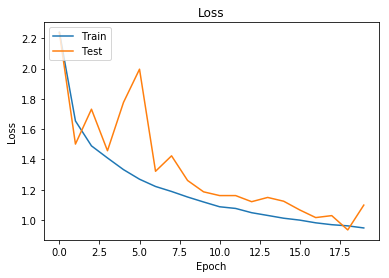

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()